# Phase 1 - (Convolutional) Neural Networks

Please follow the notebook in order. Make sure to add code where indicated by `''' TODO '''` or `# YOUR CODE HERE`. Ensure your notebook is easy to follow. All written report answers should be provided in the notebook itself.

You may find [this](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) pytorch tutorial helpful.

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
import time

## 1. Loading & Visualizing Data

Please use MNIST for this Phase. MNIST is a digit classification dataset, with greyscale 28x28 images, and 10 classes (numbers 0-9). See [documentaion.](https://pytorch.org/vision/0.15/generated/torchvision.datasets.MNIST.html) You can also see the MNIST_Tutorial.ipynb

Please complete loading the data.

Please also complete `show_imgs()`. Function should input the dataloader, and show random 10 images and their labels as title to plot. Make sure the 10 images are organized in a grid or format or with matplotlib axis.

In [ ]:
train_data = datasets.MNIST(root = './data', train = True, transform = transforms.ToTensor(), download = True)

test_data = datasets.MNIST(root = './data', train = False, transform = transforms.ToTensor())

batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)

100%|██████████| 9912422/9912422 [00:00<00:00, 100185816.50it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 117493398.47it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 168721429.53it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17606773.35it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



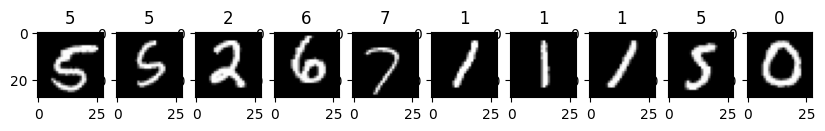

In [ ]:
def show_imgs(dataloader, n_images=10):
    images, labels = next(iter(dataloader))
    fig, axs = plt.subplots(1,10, figsize=(10,5))
    for i in range(n_images):
        ax = axs[i]
        ax.imshow(images[i].squeeze(0), cmap='gray')
        ax.set_title(f'{labels[i]}')
        #ax.axis('off')
    plt.show()
# remove axis
#usage:
show_imgs(train_loader, n_images=10)

## 2. Utility Functions

Please complete `train()` and `plot_learning_curves()` functions. `test_accuracy()` has already been provided to you.

In [ ]:
def test_accuracy(model, test_loader, input_size, device):
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for test_data in test_loader:
            images, labels = test_data[0].cuda(), test_data[1].cuda()
#             images = images.view(-1, input_size)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy: %d %%' % (100 * correct / total))

### 2.1 Train Function
Please refer to the train function in `MNIST_Classifier.ipynb` to complete this function. You will need to store the loss and accuracies per iteration to plot. Please print the loss, accuracy and time taken for training each epoch.

In [ ]:
def train(model, loss_fn, optimizer, train_loader, valid_loader, batch_size, num_epochs, device):
    if device is not None:
        model.to(device)
    else:
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model.to(device)

    train_losses = []
    train_accuracies = []
    valid_losses = []  # Track validation loss
    valid_accuracies = []  # Track validation accuracy
    validate_every = 100
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        start_time = time.time()

        # Training phase
        model.train()
        for i, data in enumerate(train_loader, 0):
            images, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Print statistics on every 100th iteration
            if (i + 1) % validate_every == 0:
                train_loss = running_loss / validate_every
                train_accuracy = 100 * correct / (validate_every * labels.size(0))

                # Validation phase
                model.eval()
                valid_running_loss = 0.0
                valid_correct = 0
                valid_total = 0
                for j, valid_data in enumerate(valid_loader, 0):
                    valid_images, valid_labels = valid_data[0].to(device), valid_data[1].to(device)
                    valid_outputs = model(valid_images)
                    valid_loss = loss_fn(valid_outputs, valid_labels)
                    valid_running_loss += valid_loss.item()
                    _, valid_predicted = torch.max(valid_outputs.data, 1)
                    valid_total += valid_labels.size(0)
                    valid_correct += (valid_predicted == valid_labels).sum().item()

                valid_loss = valid_running_loss / len(valid_loader)
                valid_accuracy = 100 * valid_correct / valid_total

                end_time = time.time()
                elapsed_time = end_time - start_time

                # Print statistics for every 100th iteration
                print('Epoch [%d/%d], Step [%d/%d], Train Loss: %.4f, Train Accuracy: %.4f, Valid Loss: %.4f, Valid Accuracy: %.4f, Time: %.2fs'
                      % (epoch + 1, num_epochs, i + 1, len(train_loader), train_loss, train_accuracy, valid_loss, valid_accuracy, elapsed_time))

                # Append to the lists
                train_losses.append(running_loss / 100)
                train_accuracies.append(train_accuracy)
                valid_losses.append(valid_loss)
                valid_accuracies.append(valid_accuracy)

                running_loss = 0
                correct = 0

        print('Train Loss: %.4f, Train Accuracy: %.4f, Valid Loss: %.4f, Valid Accuracy: %.4f, Time: %.2fs'
                      % (sum(train_losses)/len(train_losses), sum(train_accuracies)/len(train_accuracies), sum(valid_losses)/len(valid_losses), sum(valid_accuracies)/len(valid_accuracies), elapsed_time))
        print('')
    return train_losses, train_accuracies, valid_losses, valid_accuracies

### 2.2 Plot Learning Curves Function
Plot the loss and accuracies from training

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curve(train_losses, train_accuracies, valid_losses, valid_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='blue')
    plt.plot(epochs, valid_losses, label='Validation Loss', color='red')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Losses')
    plt.legend()

    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy', color='red')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title('Accuracies')
    plt.legend()

    plt.tight_layout()
    plt.show()

## 3) Define CNNs

A 1-Layer Architecture is already defined for you (`Net`) as a reference. Please complete the definitions of the 2-Layer CNN (`Net2`), 5-Layer CNN (`Net5`). The network architecture definitions are provided to you. You must calculate some dimensions yourself.

**NOTE:** For now, please use ReLU activation. You will experiment with other activations in Section 5.

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_size, 500)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(500, num_classes)

    def forward(self,x):
        x = x.view(-1, input_size)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

### 3.1) 2-Layer CNN
Complete `Net2` class.

 Network Architecture:
* ***Layer 1 (Input)***: Convolutional; input channel = 1, output channel = 20, kernel size = 3, step size = 1.
* ***Layer 2 (Output)***: Fully connected; input dimension = < you find out >, output dimension = < you find out >.

In [ ]:
# Define 2-Layer Network
class Net2(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net2,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=3, stride=1)
        # ((N - 2P) / S  ) + 1
        self.fc1 = nn.Linear(20 * 26 * 26, num_classes)
        self.relu = nn.ReLU()

    def forward(self,x):
        out = self.conv1(x)
        out = self.relu(out)
        out = out.view(-1, 20 * 26 * 26)
        out = self.fc1(out)
        return out

## 4) Train and Evaluate

### 4.1) Here, you must test your utility functions (`train()` and `plot_learning_curves()`)with the 1-Layer Model. Please at this stage ensure your utility functions are working correctly.

**NOTE**: You can repeatedly use this below code black in Section 5 to run experiments, while making changes to the hyperparameters as requested.

Epoch [1/5], Step [100/1875], Train Loss: 0.5850, Train Accuracy: 81.7188, Valid Loss: 0.4369, Valid Accuracy: 87.7200, Time: 4.40s
Epoch [1/5], Step [200/1875], Train Loss: 0.3769, Train Accuracy: 88.8438, Valid Loss: 0.2645, Valid Accuracy: 91.4200, Time: 6.12s
Epoch [1/5], Step [300/1875], Train Loss: 0.3018, Train Accuracy: 91.0625, Valid Loss: 0.2570, Valid Accuracy: 92.2900, Time: 7.84s
Epoch [1/5], Step [400/1875], Train Loss: 0.2368, Train Accuracy: 93.0312, Valid Loss: 0.2178, Valid Accuracy: 93.2200, Time: 9.64s
Epoch [1/5], Step [500/1875], Train Loss: 0.2444, Train Accuracy: 93.0625, Valid Loss: 0.2312, Valid Accuracy: 93.3000, Time: 12.01s
Epoch [1/5], Step [600/1875], Train Loss: 0.2433, Train Accuracy: 93.0625, Valid Loss: 0.2892, Valid Accuracy: 91.6100, Time: 13.72s
Epoch [1/5], Step [700/1875], Train Loss: 0.2041, Train Accuracy: 93.7812, Valid Loss: 0.2131, Valid Accuracy: 94.1300, Time: 15.49s
Epoch [1/5], Step [800/1875], Train Loss: 0.2109, Train Accuracy: 93.6875

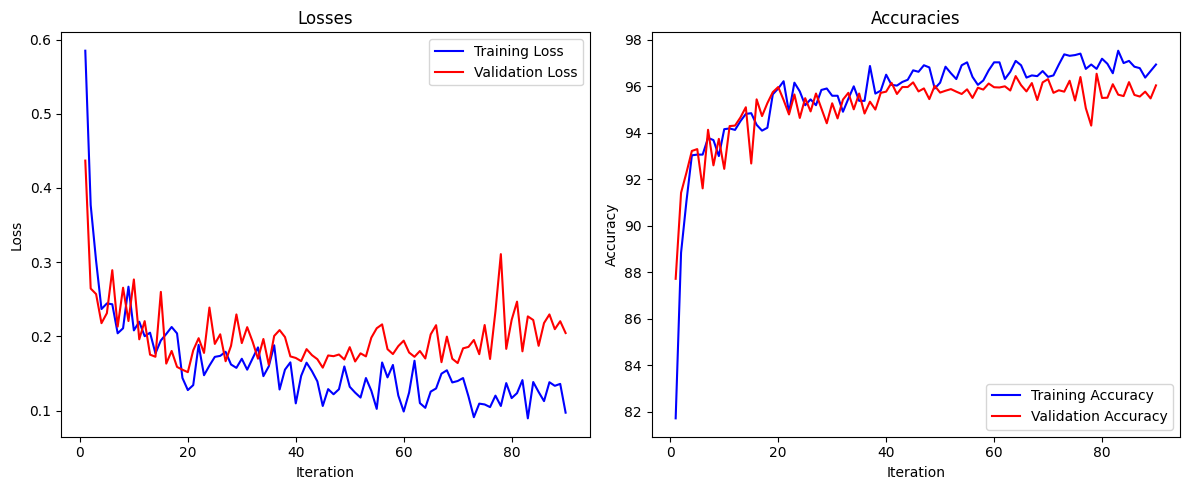

Accuracy: 96 %


In [ ]:
# Define Parameters
input_size = 784
num_classes = 10
lr = 0.01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
train_losses, train_accuracies, valid_losses, valid_accuracies = train(net, loss_function, optimizer, train_loader, test_loader, 32, num_epochs, device)

# Plot Learning Curves
plot_learning_curve(train_losses, train_accuracies, valid_losses, valid_accuracies)

# Evaluate on Test Set
test_accuracy(model=net, test_loader=test_loader, input_size=input_size, device=device)

### 4.2) Please also train your 2-Layer network to ensure it is working properly.

Epoch [1/5], Step [100/1875], Train Loss: 1.4301, Train Accuracy: 76.4375, Valid Loss: 0.2677, Valid Accuracy: 92.0800, Time: 5.73s
Epoch [1/5], Step [200/1875], Train Loss: 0.2236, Train Accuracy: 93.3750, Valid Loss: 0.1554, Valid Accuracy: 95.4100, Time: 7.55s
Epoch [1/5], Step [300/1875], Train Loss: 0.1633, Train Accuracy: 95.2188, Valid Loss: 0.1458, Valid Accuracy: 95.6300, Time: 9.74s
Epoch [1/5], Step [400/1875], Train Loss: 0.1645, Train Accuracy: 94.8125, Valid Loss: 0.1271, Valid Accuracy: 96.4800, Time: 11.39s
Epoch [1/5], Step [500/1875], Train Loss: 0.1499, Train Accuracy: 95.8750, Valid Loss: 0.1528, Valid Accuracy: 95.4100, Time: 13.09s
Epoch [1/5], Step [600/1875], Train Loss: 0.1196, Train Accuracy: 96.2500, Valid Loss: 0.1291, Valid Accuracy: 95.9000, Time: 14.83s
Epoch [1/5], Step [700/1875], Train Loss: 0.1221, Train Accuracy: 96.1562, Valid Loss: 0.1283, Valid Accuracy: 95.8800, Time: 16.58s
Epoch [1/5], Step [800/1875], Train Loss: 0.1305, Train Accuracy: 96.312

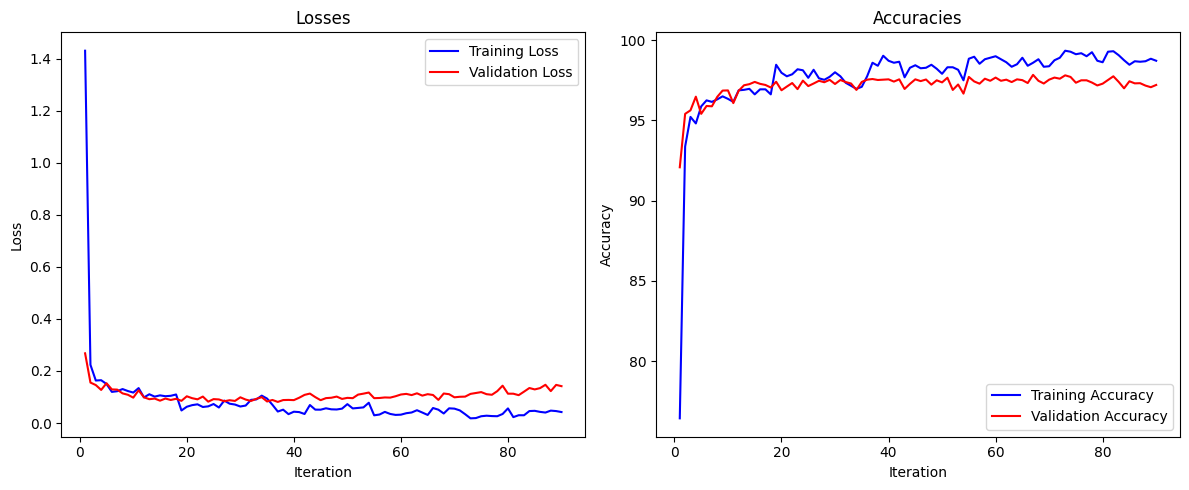

Accuracy: 97 %


In [ ]:
# Define Parameters
input_size = 784
num_classes = 10
lr = 0.01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
train_losses, train_accuracies, valid_losses, valid_accuracies = train(net, loss_function, optimizer, train_loader, test_loader, 32, num_epochs, device)

# Plot Learning Curves
plot_learning_curve(train_losses, train_accuracies, valid_losses, valid_accuracies)

# Evaluate on Test Set
test_accuracy(model=net, test_loader=test_loader, input_size=input_size, device=device)

## 5) Experiments and Reporting

In this section you will use your utility functioins and model definitons from before, and test for different scenarios. There are report questions you must answer for all sections below. Please use the loss, accuracy, and learning curves to help answer questions.

**NOTE:** In this section we will only change different parameters, so you can call most of your functions from previous sections. Any modifications needed in code asked by the questions in Section 5, please add them in the code sections indicated by `# YOUR CODE HERE`

### 5.1) Learning Curves

#### **Q 5.1) What is a Learning curve and why is it useful? You can refer to learning curves you have plotted in Section 4.**

---

A machine learning model's performance is represented graphically as a learning curve, which varies with the volume of training data. It is a plot of the training or loss measure for a model against the total number of epochs or iterations. It's useful as it let's us know where the train loss and validation loss are decresing over a period of time on graph which is easier to look at compared to printing a bunch of values over and over again.



### 5.1) Learning Rates

Please plot the curves for three separate training instances with learning rates of 2e-3, 3e-4, 5e-2. Use the 2-Layer CNN.

#### **Q 5.2) For each learning rate, explain if the model is underfitting, overfitting, or is training well. Explain the difference between high learning rates and low learning rates in terms of the optimization process.**

Epoch [1/5], Step [100/1875], Train Loss: 0.7534, Train Accuracy: 77.4688, Valid Loss: 0.3114, Valid Accuracy: 91.1800, Time: 1.73s
Epoch [1/5], Step [200/1875], Train Loss: 0.3136, Train Accuracy: 90.4062, Valid Loss: 0.2552, Valid Accuracy: 92.4300, Time: 3.48s
Epoch [1/5], Step [300/1875], Train Loss: 0.2521, Train Accuracy: 92.3750, Valid Loss: 0.1979, Valid Accuracy: 94.0400, Time: 5.47s
Epoch [1/5], Step [400/1875], Train Loss: 0.1981, Train Accuracy: 94.3125, Valid Loss: 0.1607, Valid Accuracy: 95.2600, Time: 7.63s
Epoch [1/5], Step [500/1875], Train Loss: 0.1733, Train Accuracy: 94.9688, Valid Loss: 0.1380, Valid Accuracy: 95.9100, Time: 9.38s
Epoch [1/5], Step [600/1875], Train Loss: 0.1702, Train Accuracy: 95.1562, Valid Loss: 0.1602, Valid Accuracy: 95.0600, Time: 11.15s
Epoch [1/5], Step [700/1875], Train Loss: 0.1301, Train Accuracy: 96.3750, Valid Loss: 0.1113, Valid Accuracy: 96.8700, Time: 12.85s
Epoch [1/5], Step [800/1875], Train Loss: 0.1459, Train Accuracy: 95.6562,

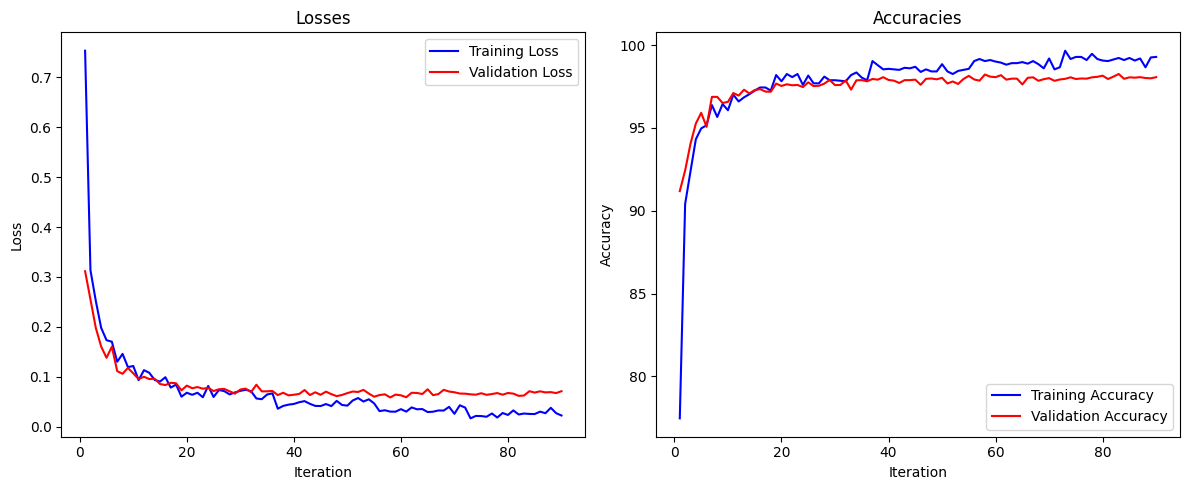

Accuracy: 98 %


In [ ]:
# YOUR CODE HERE
input_size = 784
num_classes = 10
lr = 2e-3
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
train_losses, train_accuracies, valid_losses, valid_accuracies = train(net, loss_function, optimizer, train_loader, test_loader, 32, num_epochs, device)

# Plot Learning Curves
plot_learning_curve(train_losses, train_accuracies, valid_losses, valid_accuracies)

# Evaluate on Test Set
test_accuracy(model=net, test_loader=test_loader, input_size=input_size, device=device)

From the graph, we can see that the model is training well since there is a significant difference in both the train and validation plots.  

Epoch [1/5], Step [100/1875], Train Loss: 1.1987, Train Accuracy: 70.2188, Valid Loss: 0.5771, Valid Accuracy: 86.1400, Time: 1.77s
Epoch [1/5], Step [200/1875], Train Loss: 0.5160, Train Accuracy: 85.0312, Valid Loss: 0.3990, Valid Accuracy: 89.5700, Time: 3.51s
Epoch [1/5], Step [300/1875], Train Loss: 0.4165, Train Accuracy: 87.8125, Valid Loss: 0.3514, Valid Accuracy: 90.4800, Time: 5.24s
Epoch [1/5], Step [400/1875], Train Loss: 0.3442, Train Accuracy: 89.5625, Valid Loss: 0.3285, Valid Accuracy: 90.7600, Time: 7.49s
Epoch [1/5], Step [500/1875], Train Loss: 0.3553, Train Accuracy: 90.1875, Valid Loss: 0.3048, Valid Accuracy: 91.2600, Time: 9.28s
Epoch [1/5], Step [600/1875], Train Loss: 0.2896, Train Accuracy: 91.3750, Valid Loss: 0.2939, Valid Accuracy: 91.4700, Time: 11.03s
Epoch [1/5], Step [700/1875], Train Loss: 0.3348, Train Accuracy: 90.3750, Valid Loss: 0.2966, Valid Accuracy: 91.6300, Time: 12.74s
Epoch [1/5], Step [800/1875], Train Loss: 0.2859, Train Accuracy: 91.5625,

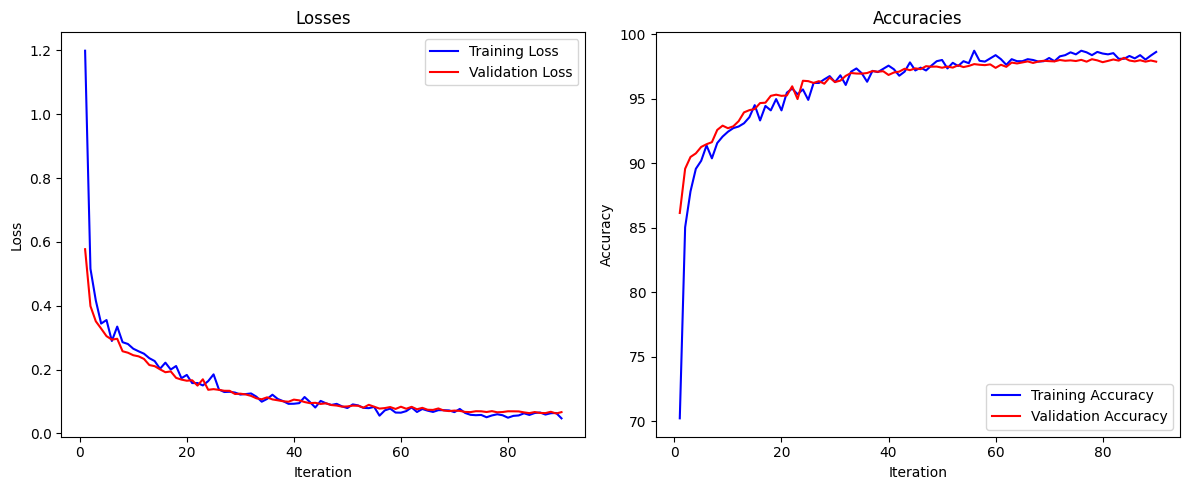

Accuracy: 98 %


In [ ]:
input_size = 784
num_classes = 10
lr = 3e-4
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
train_losses, train_accuracies, valid_losses, valid_accuracies = train(net, loss_function, optimizer, train_loader, test_loader, 32, num_epochs, device)

# Plot Learning Curves
plot_learning_curve(train_losses, train_accuracies, valid_losses, valid_accuracies)

# Evaluate on Test Set
test_accuracy(model=net, test_loader=test_loader, input_size=input_size, device=device)

From the graph, we can see that the model is overfitting since both the train and validation plots are almost converging with each other.  

Epoch [1/5], Step [100/1875], Train Loss: 1.9689, Train Accuracy: 80.7188, Valid Loss: 0.3586, Valid Accuracy: 91.0800, Time: 1.74s
Epoch [1/5], Step [200/1875], Train Loss: 0.3824, Train Accuracy: 89.8125, Valid Loss: 0.3164, Valid Accuracy: 91.5600, Time: 3.45s
Epoch [1/5], Step [300/1875], Train Loss: 0.3389, Train Accuracy: 90.7500, Valid Loss: 0.2783, Valid Accuracy: 91.5300, Time: 5.16s
Epoch [1/5], Step [400/1875], Train Loss: 0.3139, Train Accuracy: 91.1250, Valid Loss: 0.2205, Valid Accuracy: 93.5200, Time: 6.84s
Epoch [1/5], Step [500/1875], Train Loss: 0.3019, Train Accuracy: 91.3125, Valid Loss: 0.2588, Valid Accuracy: 92.6400, Time: 9.06s
Epoch [1/5], Step [600/1875], Train Loss: 0.3224, Train Accuracy: 91.0938, Valid Loss: 0.2699, Valid Accuracy: 92.8800, Time: 10.99s
Epoch [1/5], Step [700/1875], Train Loss: 0.3306, Train Accuracy: 91.3125, Valid Loss: 0.2299, Valid Accuracy: 93.5000, Time: 12.75s
Epoch [1/5], Step [800/1875], Train Loss: 0.2564, Train Accuracy: 92.7500,

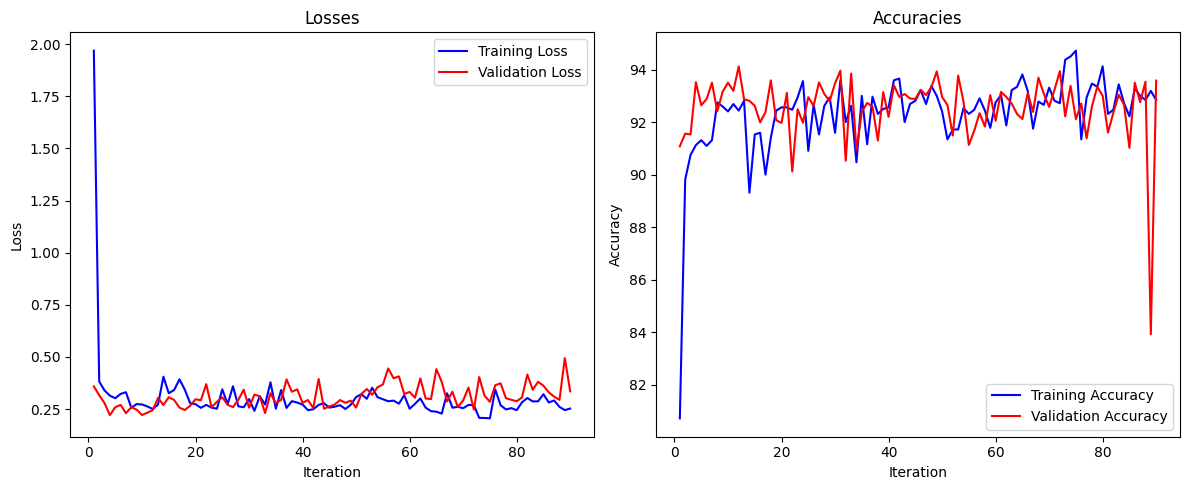

Accuracy: 93 %


In [ ]:
input_size = 784
num_classes = 10
lr = 5e-2
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
train_losses, train_accuracies, valid_losses, valid_accuracies = train(net, loss_function, optimizer, train_loader, test_loader, 32, num_epochs, device)

# Plot Learning Curves
plot_learning_curve(train_losses, train_accuracies, valid_losses, valid_accuracies)

# Evaluate on Test Set
test_accuracy(model=net, test_loader=test_loader, input_size=input_size, device=device)

From the graph, we can see that the model is overfitting since both the train and validation plots are almost converging with each other. From the above graphs, we can notice that high learning rates can lead to overfitting and unstable training, while low learning rates can result in slow convergence. However, the speed of optimization with higher learning rates is faster when compared to lower learning rates since it requires less iterations for the model to converge to a solution.

---

### 5.3) Optimizer
The optimizer we have used before is Adam. Change the optimizer to use stochastic gradient descent (SGD), and SGD with momentum. Use 2-Layer CNN.

#### **Q 5.3) Explain the differences in Adam and both SGD optimizations. Compare the results of each optimizer based on the learning curves.**

Epoch [1/5], Step [100/1875], Train Loss: 1.1968, Train Accuracy: 73.2188, Valid Loss: 0.6099, Valid Accuracy: 85.3900, Time: 1.80s
Epoch [1/5], Step [200/1875], Train Loss: 0.5461, Train Accuracy: 84.8125, Valid Loss: 0.4339, Valid Accuracy: 88.0600, Time: 3.60s
Epoch [1/5], Step [300/1875], Train Loss: 0.4167, Train Accuracy: 88.0625, Valid Loss: 0.3874, Valid Accuracy: 89.0400, Time: 5.36s
Epoch [1/5], Step [400/1875], Train Loss: 0.3970, Train Accuracy: 88.7188, Valid Loss: 0.3615, Valid Accuracy: 89.9300, Time: 7.13s
Epoch [1/5], Step [500/1875], Train Loss: 0.4066, Train Accuracy: 88.3125, Valid Loss: 0.3521, Valid Accuracy: 89.8200, Time: 9.30s
Epoch [1/5], Step [600/1875], Train Loss: 0.3766, Train Accuracy: 88.9062, Valid Loss: 0.3432, Valid Accuracy: 90.0000, Time: 11.26s
Epoch [1/5], Step [700/1875], Train Loss: 0.3625, Train Accuracy: 89.2500, Valid Loss: 0.3274, Valid Accuracy: 90.6800, Time: 13.00s
Epoch [1/5], Step [800/1875], Train Loss: 0.3319, Train Accuracy: 89.9375,

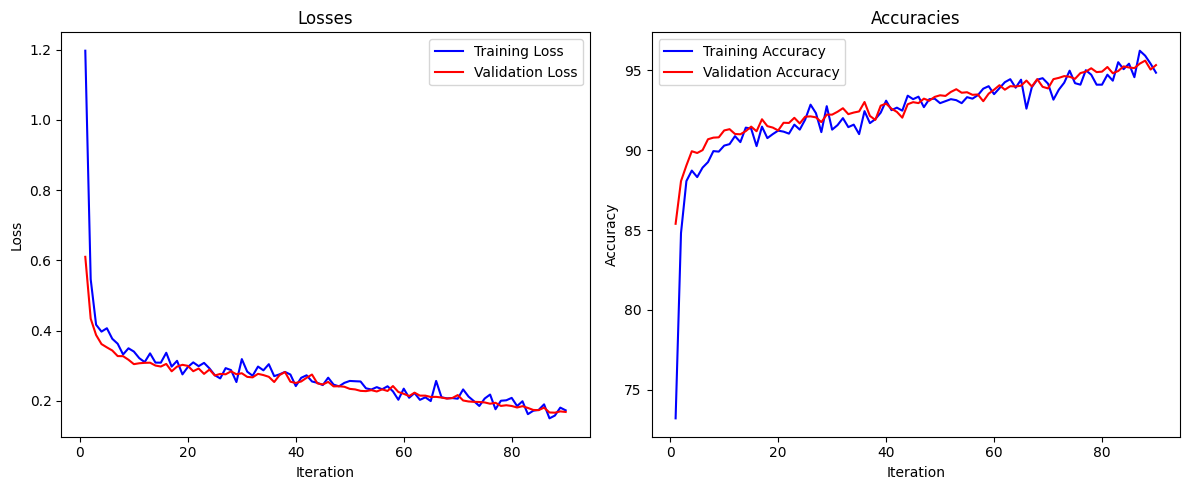

Accuracy: 95 %


In [ ]:
# YOUR CODE HERE
input_size = 784
num_classes = 10
lr = 0.01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# Train Model
train_losses, train_accuracies, valid_losses, valid_accuracies = train(net, loss_function, optimizer, train_loader, test_loader, 32, num_epochs, device)

# Plot Learning Curves
plot_learning_curve(train_losses, train_accuracies, valid_losses, valid_accuracies)

# Evaluate on Test Set
test_accuracy(model=net, test_loader=test_loader, input_size=input_size, device=device)

Epoch [1/5], Step [100/1875], Train Loss: 0.7605, Train Accuracy: 75.6250, Valid Loss: 0.3967, Valid Accuracy: 88.2800, Time: 1.81s
Epoch [1/5], Step [200/1875], Train Loss: 0.3899, Train Accuracy: 89.0312, Valid Loss: 0.3730, Valid Accuracy: 88.8300, Time: 3.63s
Epoch [1/5], Step [300/1875], Train Loss: 0.3362, Train Accuracy: 89.7500, Valid Loss: 0.2953, Valid Accuracy: 91.7100, Time: 5.35s
Epoch [1/5], Step [400/1875], Train Loss: 0.3290, Train Accuracy: 90.5625, Valid Loss: 0.2685, Valid Accuracy: 92.3800, Time: 7.14s
Epoch [1/5], Step [500/1875], Train Loss: 0.2740, Train Accuracy: 91.9688, Valid Loss: 0.2450, Valid Accuracy: 92.9200, Time: 9.22s
Epoch [1/5], Step [600/1875], Train Loss: 0.2420, Train Accuracy: 93.3438, Valid Loss: 0.2055, Valid Accuracy: 94.4600, Time: 11.26s
Epoch [1/5], Step [700/1875], Train Loss: 0.2425, Train Accuracy: 93.2812, Valid Loss: 0.2035, Valid Accuracy: 94.3900, Time: 12.97s
Epoch [1/5], Step [800/1875], Train Loss: 0.1977, Train Accuracy: 93.9375,

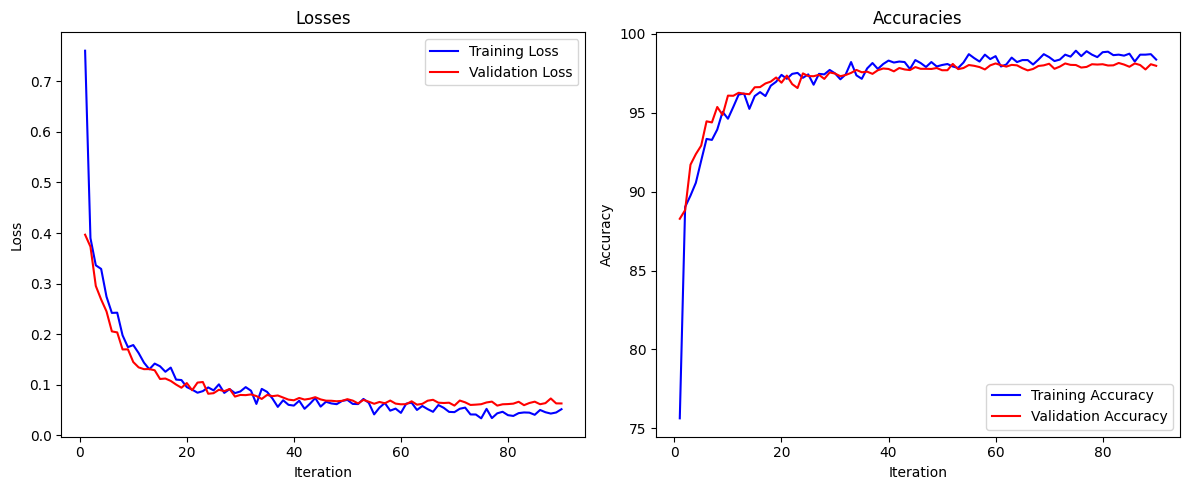

Accuracy: 97 %


In [ ]:
# YOUR CODE HERE
input_size = 784
num_classes = 10
lr = 0.01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# Train Model
train_losses, train_accuracies, valid_losses, valid_accuracies = train(net, loss_function, optimizer, train_loader, test_loader, 32, num_epochs, device)

# Plot Learning Curves
plot_learning_curve(train_losses, train_accuracies, valid_losses, valid_accuracies)

# Evaluate on Test Set
test_accuracy(model=net, test_loader=test_loader, input_size=input_size, device=device)

From the plots, we can see that with SGD alone our graph is overfitting. However, when we change the momentum to 0.9, we see that our graph is training well. When training our model with Adam, we can see that it adjusts the learning rates for each parameter based on past gradients, allowing for different learning rates for different parameters and encorporates momentum to speed up the training. SGD on the other hand, computes the gradient of the loss function with respect to a small random subset of the training data and updates the parameters. SGD does not adapt the learning rate and momentum and requires manuall tuning, which makes it a better fit in training the model.

---

### 5.4) Initializing Weights

Initialize the weights to all zeros, all ones and all randomly initialized with a normal distribution. Use 2-Layer CNN.

#### **Q 5.4) How is the training process affected when we initialize our network weights differently? Based on what you observe, give a recommendation as to how weights should be initialized. Explain your reasoning.**

Epoch [1/5], Step [100/1875], Train Loss: 2.3028, Train Accuracy: 10.2812, Valid Loss: 2.3029, Valid Accuracy: 10.3200, Time: 1.74s
Epoch [1/5], Step [200/1875], Train Loss: 2.3036, Train Accuracy: 9.8750, Valid Loss: 2.3029, Valid Accuracy: 10.3200, Time: 3.46s
Epoch [1/5], Step [300/1875], Train Loss: 2.3030, Train Accuracy: 10.1250, Valid Loss: 2.3029, Valid Accuracy: 10.3200, Time: 5.15s
Epoch [1/5], Step [400/1875], Train Loss: 2.3026, Train Accuracy: 10.5938, Valid Loss: 2.3029, Valid Accuracy: 10.3200, Time: 6.86s
Epoch [1/5], Step [500/1875], Train Loss: 2.3028, Train Accuracy: 9.9688, Valid Loss: 2.3029, Valid Accuracy: 10.3200, Time: 8.85s
Epoch [1/5], Step [600/1875], Train Loss: 2.3028, Train Accuracy: 10.2812, Valid Loss: 2.3029, Valid Accuracy: 10.3200, Time: 11.09s
Epoch [1/5], Step [700/1875], Train Loss: 2.3039, Train Accuracy: 9.6875, Valid Loss: 2.3029, Valid Accuracy: 10.3200, Time: 12.85s
Epoch [1/5], Step [800/1875], Train Loss: 2.3035, Train Accuracy: 9.5625, Val

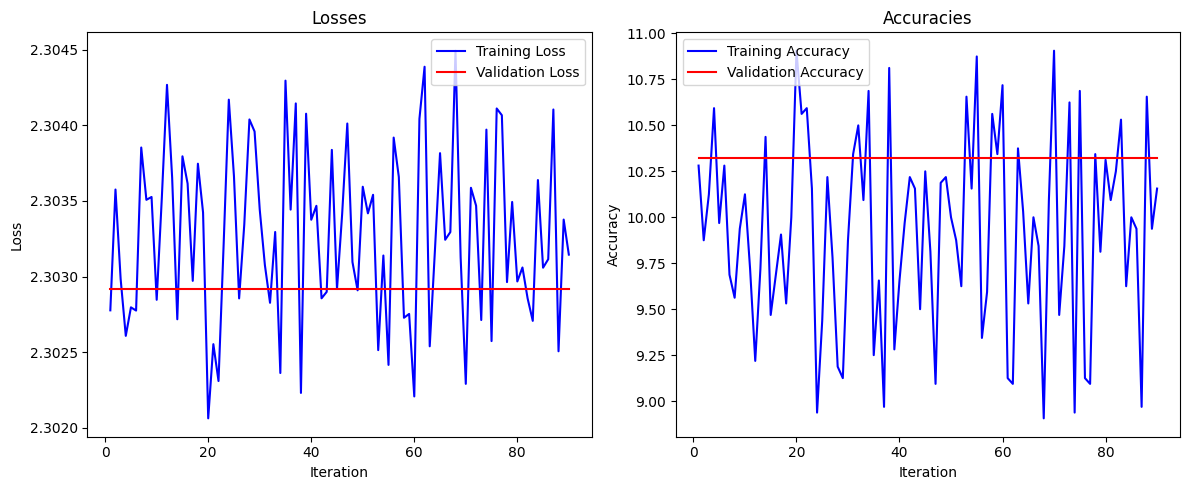

Accuracy: 10 %


In [ ]:
# YOUR CODE HERE
import torch.nn.init as init
net_zeros = Net2(input_size, num_classes)
init.zeros_(net_zeros.conv1.weight)
train_losses_zeros, train_accuracies_zeros, valid_losses, valid_accuracies = train(net_zeros, loss_function, optimizer, train_loader, test_loader, 32, num_epochs, device)
plot_learning_curve(train_losses_zeros, train_accuracies_zeros, valid_losses, valid_accuracies)
test_accuracy(model=net_zeros, test_loader=test_loader, input_size=input_size, device=device)

Epoch [1/5], Step [100/1875], Train Loss: 3.2115, Train Accuracy: 5.9375, Valid Loss: 3.2514, Valid Accuracy: 5.9800, Time: 1.94s
Epoch [1/5], Step [200/1875], Train Loss: 3.2212, Train Accuracy: 6.1562, Valid Loss: 3.2514, Valid Accuracy: 5.9800, Time: 4.27s
Epoch [1/5], Step [300/1875], Train Loss: 3.2069, Train Accuracy: 6.4688, Valid Loss: 3.2514, Valid Accuracy: 5.9800, Time: 6.15s
Epoch [1/5], Step [400/1875], Train Loss: 3.1864, Train Accuracy: 6.4375, Valid Loss: 3.2514, Valid Accuracy: 5.9800, Time: 7.91s
Epoch [1/5], Step [500/1875], Train Loss: 3.2294, Train Accuracy: 5.6875, Valid Loss: 3.2514, Valid Accuracy: 5.9800, Time: 9.65s
Epoch [1/5], Step [600/1875], Train Loss: 3.1893, Train Accuracy: 6.0938, Valid Loss: 3.2514, Valid Accuracy: 5.9800, Time: 11.80s
Epoch [1/5], Step [700/1875], Train Loss: 3.2224, Train Accuracy: 6.3438, Valid Loss: 3.2514, Valid Accuracy: 5.9800, Time: 13.79s
Epoch [1/5], Step [800/1875], Train Loss: 3.1980, Train Accuracy: 5.9062, Valid Loss: 3.

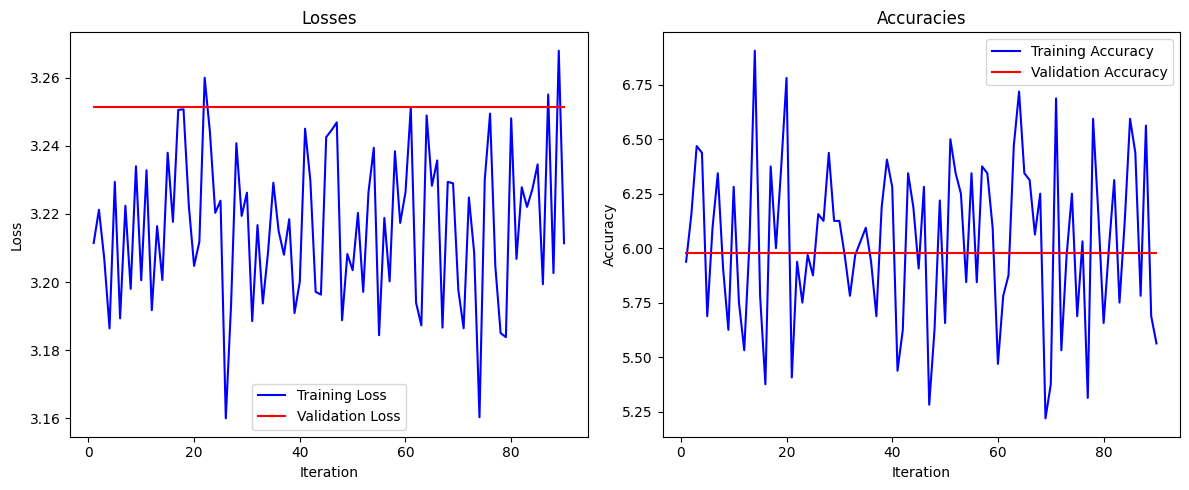

Accuracy: 5 %


In [ ]:
net_ones = Net2(input_size, num_classes)
init.ones_(net_ones.conv1.weight)
train_losses_ones, train_accuracies_ones, valid_losses, valid_accuracies = train(net_ones, loss_function, optimizer, train_loader, test_loader, 32, num_epochs, device)
plot_learning_curve(train_losses_ones, train_accuracies_ones, valid_losses, valid_accuracies)
test_accuracy(model=net_ones, test_loader=test_loader, input_size=input_size, device=device)

Epoch [1/5], Step [100/1875], Train Loss: 2.5482, Train Accuracy: 11.5938, Valid Loss: 2.5524, Valid Accuracy: 12.6000, Time: 1.88s
Epoch [1/5], Step [200/1875], Train Loss: 2.5372, Train Accuracy: 12.8125, Valid Loss: 2.5524, Valid Accuracy: 12.6000, Time: 4.15s
Epoch [1/5], Step [300/1875], Train Loss: 2.5665, Train Accuracy: 12.2812, Valid Loss: 2.5524, Valid Accuracy: 12.6000, Time: 5.89s
Epoch [1/5], Step [400/1875], Train Loss: 2.5449, Train Accuracy: 13.3438, Valid Loss: 2.5524, Valid Accuracy: 12.6000, Time: 7.61s
Epoch [1/5], Step [500/1875], Train Loss: 2.5163, Train Accuracy: 12.8125, Valid Loss: 2.5524, Valid Accuracy: 12.6000, Time: 9.32s
Epoch [1/5], Step [600/1875], Train Loss: 2.5575, Train Accuracy: 12.7812, Valid Loss: 2.5524, Valid Accuracy: 12.6000, Time: 11.04s
Epoch [1/5], Step [700/1875], Train Loss: 2.5423, Train Accuracy: 12.3125, Valid Loss: 2.5524, Valid Accuracy: 12.6000, Time: 12.74s
Epoch [1/5], Step [800/1875], Train Loss: 2.5508, Train Accuracy: 12.3750,

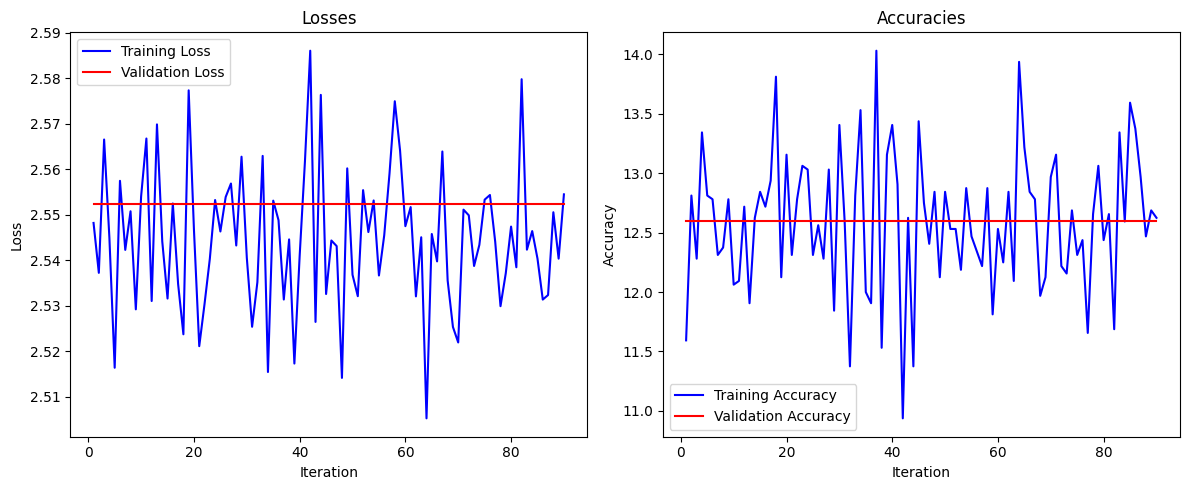

Accuracy: 12 %


In [ ]:
net_random = Net2(input_size, num_classes)
init.normal_(net_random.conv1.weight, mean=0, std=1)
train_losses_random, train_accuracies_random, valid_losses, valid_accuracies = train(net_random, loss_function, optimizer, train_loader, test_loader, 32, num_epochs, device)
plot_learning_curve(train_losses_random, train_accuracies_random, valid_losses, valid_accuracies)
test_accuracy(model=net_random, test_loader=test_loader, input_size=input_size, device=device)

When we change our weights to zeros, ones, or randoms, we can see that our accuray for training falls and our validation accuracy and loss stay at a certain value indicating that the model without weights doesn't check for the model that should be tested. When we initialize our model to zero, we can see that it leads to symmetric weight updates where all neurons in a layer will learn the same features, resulting in a lack of diversity in the network's representation. When we initialize our model to ones, we can see that it leads to symmetric weight updates and a lack of diversity in features where it will not be able to capture complex patterns. When we initialize our model to normal random distribution, we can see that our complex data doesn't train well and is not able to capture the patterns either. From this we understand that weights play an important role in training our data.


---

### 5.5) Activation Function

Please change the relu function in the example code to a tanh function. Use 2-Layer CNN.

#### **Q 5.5) How does changing the activation function to tanh affect the performance. Is it better or worse? Explain why.**

In [ ]:
# YOUR CODE HERE
class Net_Tan(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net_Tan,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=3, stride=1)
        # ((N - 2P) / S  ) + 1
        self.fc1 = nn.Linear(20 * 26 * 26, num_classes)
        self.Tanh = nn.Tanh()

    def forward(self,x):
        out = self.conv1(x)
        out = self.Tanh(out)
        out = out.view(-1, 20 * 26 * 26)
        out = self.fc1(out)
        return out

Epoch [1/5], Step [100/1875], Train Loss: 2.9165, Train Accuracy: 74.6562, Valid Loss: 0.6849, Valid Accuracy: 86.3900, Time: 1.81s
Epoch [1/5], Step [200/1875], Train Loss: 0.5978, Train Accuracy: 86.0000, Valid Loss: 0.4408, Valid Accuracy: 88.2300, Time: 3.62s
Epoch [1/5], Step [300/1875], Train Loss: 0.4340, Train Accuracy: 88.0938, Valid Loss: 0.4240, Valid Accuracy: 88.5500, Time: 5.38s
Epoch [1/5], Step [400/1875], Train Loss: 0.4071, Train Accuracy: 88.7500, Valid Loss: 0.3476, Valid Accuracy: 89.8800, Time: 7.81s
Epoch [1/5], Step [500/1875], Train Loss: 0.3936, Train Accuracy: 88.4688, Valid Loss: 0.4268, Valid Accuracy: 87.1500, Time: 9.56s
Epoch [1/5], Step [600/1875], Train Loss: 0.4239, Train Accuracy: 87.9062, Valid Loss: 0.4058, Valid Accuracy: 89.1400, Time: 11.25s
Epoch [1/5], Step [700/1875], Train Loss: 0.4338, Train Accuracy: 87.8438, Valid Loss: 0.3717, Valid Accuracy: 89.1300, Time: 12.97s
Epoch [1/5], Step [800/1875], Train Loss: 0.4304, Train Accuracy: 88.0000,

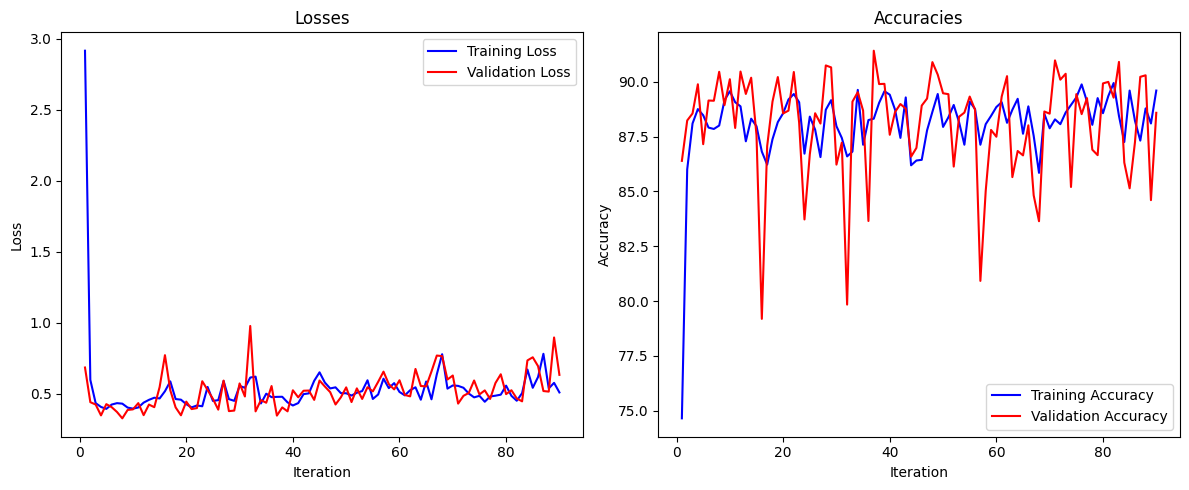

Accuracy: 89 %


In [ ]:
input_size = 784
num_classes = 10
lr = 0.01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net_Tan(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
train_losses, train_accuracies, valid_losses, valid_accuracies = train(net, loss_function, optimizer, train_loader, test_loader, 32, num_epochs, device)

# Plot Learning Curves
plot_learning_curve(train_losses, train_accuracies, valid_losses, valid_accuracies)

# Evaluate on Test Set
test_accuracy(model=net, test_loader=test_loader, input_size=input_size, device=device)

Changing the model from relu to Tanh makes the model worse and we can see that it overfits in the learning curves. This might be because the tanh function might not be initializing the weights, learning rates orbatch size in the model properly. This can be fixed by improving the hyperparameters or by adding regularization techniques.

---

### 5.6) Batch Size

Please use batch size of 128, 256, 512. Use 2-Layer CNN.

#### **Q 5.6) How does changing batch size affect the training process?**

Epoch [1/5], Step [100/1875], Train Loss: 1.2085, Train Accuracy: 78.1250, Valid Loss: 0.2189, Valid Accuracy: 93.8900, Time: 1.71s
Epoch [1/5], Step [200/1875], Train Loss: 0.1935, Train Accuracy: 94.1875, Valid Loss: 0.1799, Valid Accuracy: 94.4600, Time: 3.43s
Epoch [1/5], Step [300/1875], Train Loss: 0.1791, Train Accuracy: 94.5625, Valid Loss: 0.1521, Valid Accuracy: 95.4200, Time: 5.15s
Epoch [1/5], Step [400/1875], Train Loss: 0.1623, Train Accuracy: 95.5625, Valid Loss: 0.1326, Valid Accuracy: 95.9500, Time: 7.05s
Epoch [1/5], Step [500/1875], Train Loss: 0.1453, Train Accuracy: 95.9062, Valid Loss: 0.1348, Valid Accuracy: 96.1400, Time: 9.36s
Epoch [1/5], Step [600/1875], Train Loss: 0.1570, Train Accuracy: 95.6250, Valid Loss: 0.1285, Valid Accuracy: 96.2500, Time: 11.15s
Epoch [1/5], Step [700/1875], Train Loss: 0.1463, Train Accuracy: 95.6562, Valid Loss: 0.1078, Valid Accuracy: 96.5400, Time: 12.91s
Epoch [1/5], Step [800/1875], Train Loss: 0.1408, Train Accuracy: 95.8125,

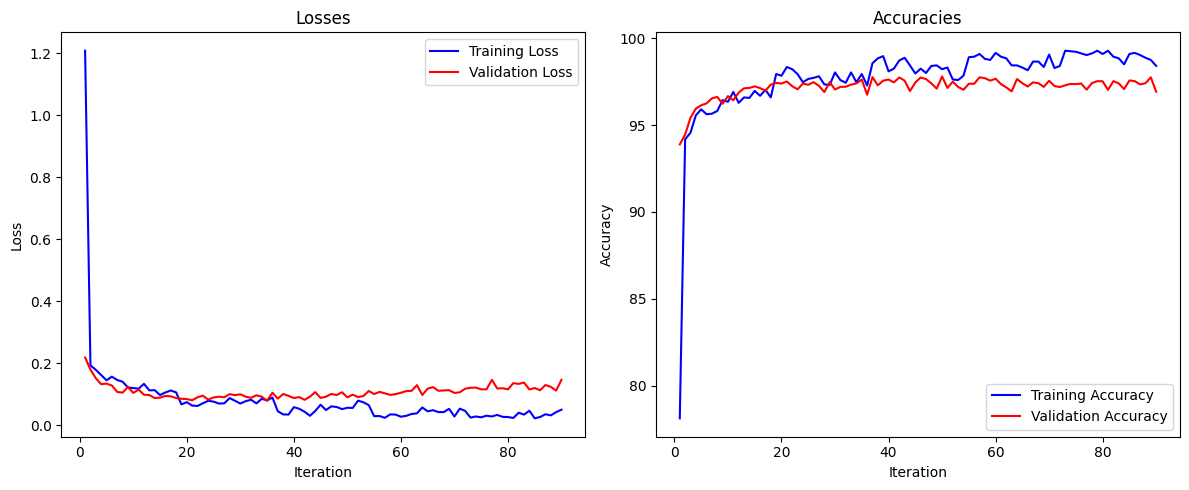

Accuracy: 97 %


In [ ]:
# YOUR CODE HERE
input_size = 784
num_classes = 10
lr = 0.01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
train_losses, train_accuracies, valid_losses, valid_accuracies = train(net, loss_function, optimizer, train_loader, test_loader, 128, num_epochs, device)

# Plot Learning Curves
plot_learning_curve(train_losses, train_accuracies, valid_losses, valid_accuracies)

# Evaluate on Test Set
test_accuracy(model=net, test_loader=test_loader, input_size=input_size, device=device)

Epoch [1/5], Step [100/1875], Train Loss: 0.7632, Train Accuracy: 81.6250, Valid Loss: 0.2249, Valid Accuracy: 93.6200, Time: 1.75s
Epoch [1/5], Step [200/1875], Train Loss: 0.1878, Train Accuracy: 94.8125, Valid Loss: 0.1589, Valid Accuracy: 95.4200, Time: 3.53s
Epoch [1/5], Step [300/1875], Train Loss: 0.2014, Train Accuracy: 93.8750, Valid Loss: 0.1530, Valid Accuracy: 95.5300, Time: 5.48s
Epoch [1/5], Step [400/1875], Train Loss: 0.1627, Train Accuracy: 95.0625, Valid Loss: 0.1278, Valid Accuracy: 96.2700, Time: 7.82s
Epoch [1/5], Step [500/1875], Train Loss: 0.1285, Train Accuracy: 95.8750, Valid Loss: 0.1213, Valid Accuracy: 96.4000, Time: 9.60s
Epoch [1/5], Step [600/1875], Train Loss: 0.1284, Train Accuracy: 96.7188, Valid Loss: 0.1157, Valid Accuracy: 96.4400, Time: 11.38s
Epoch [1/5], Step [700/1875], Train Loss: 0.1236, Train Accuracy: 96.2812, Valid Loss: 0.1263, Valid Accuracy: 96.1400, Time: 13.12s
Epoch [1/5], Step [800/1875], Train Loss: 0.1037, Train Accuracy: 96.7188,

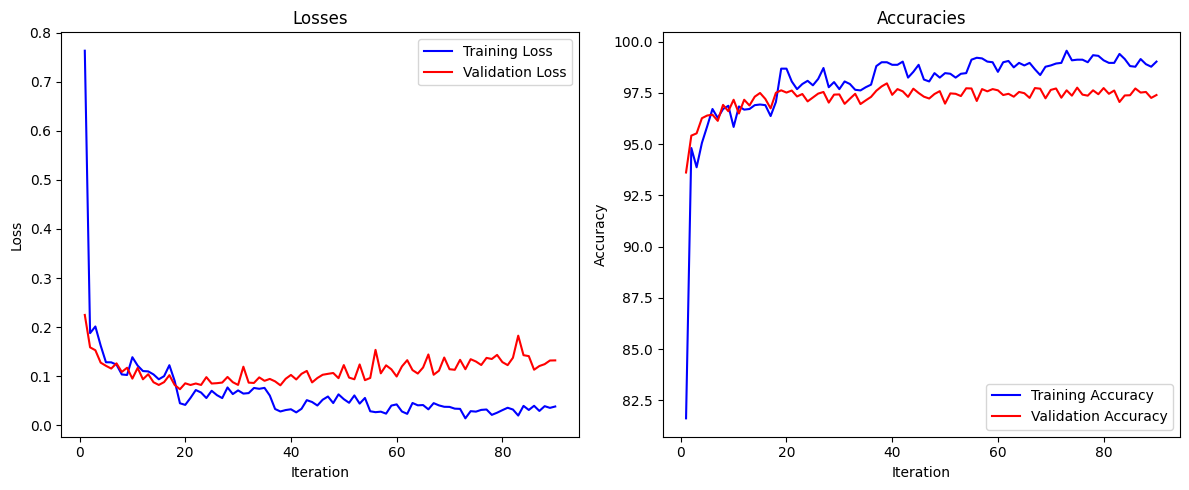

Accuracy: 97 %


In [ ]:
input_size = 784
num_classes = 10
lr = 0.01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
train_losses, train_accuracies, valid_losses, valid_accuracies = train(net, loss_function, optimizer, train_loader, test_loader, 256, num_epochs, device)

# Plot Learning Curves
plot_learning_curve(train_losses, train_accuracies, valid_losses, valid_accuracies)

# Evaluate on Test Set
test_accuracy(model=net, test_loader=test_loader, input_size=input_size, device=device)

Epoch [1/5], Step [100/1875], Train Loss: 0.9748, Train Accuracy: 80.0000, Valid Loss: 0.2699, Valid Accuracy: 92.0600, Time: 1.75s
Epoch [1/5], Step [200/1875], Train Loss: 0.2357, Train Accuracy: 92.8438, Valid Loss: 0.1752, Valid Accuracy: 94.8800, Time: 3.52s
Epoch [1/5], Step [300/1875], Train Loss: 0.1852, Train Accuracy: 94.3125, Valid Loss: 0.1590, Valid Accuracy: 95.4800, Time: 5.33s
Epoch [1/5], Step [400/1875], Train Loss: 0.1398, Train Accuracy: 95.6875, Valid Loss: 0.2215, Valid Accuracy: 93.9200, Time: 7.10s
Epoch [1/5], Step [500/1875], Train Loss: 0.1725, Train Accuracy: 94.7812, Valid Loss: 0.1828, Valid Accuracy: 94.4500, Time: 8.89s
Epoch [1/5], Step [600/1875], Train Loss: 0.1410, Train Accuracy: 95.9375, Valid Loss: 0.1264, Valid Accuracy: 96.1200, Time: 11.37s
Epoch [1/5], Step [700/1875], Train Loss: 0.1516, Train Accuracy: 95.3750, Valid Loss: 0.1002, Valid Accuracy: 96.8200, Time: 13.11s
Epoch [1/5], Step [800/1875], Train Loss: 0.1282, Train Accuracy: 96.1250,

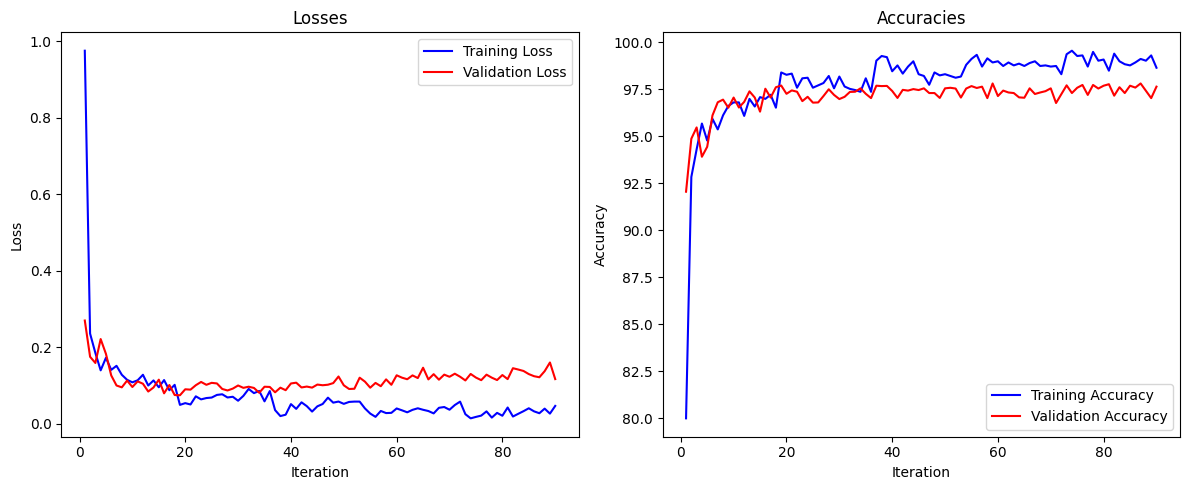

Accuracy: 97 %


In [ ]:
input_size = 784
num_classes = 10
lr = 0.01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
train_losses, train_accuracies, valid_losses, valid_accuracies = train(net, loss_function, optimizer, train_loader, test_loader, 512, num_epochs, device)

# Plot Learning Curves
plot_learning_curve(train_losses, train_accuracies, valid_losses, valid_accuracies)

# Evaluate on Test Set
test_accuracy(model=net, test_loader=test_loader, input_size=input_size, device=device)

Changing the batch size didn't have a significant change in the models. However, the overall runtime for the models decreases as we increase the batch size indicating that lead to faster convergence and less generalization.

---

### 5.7) Different Network Architectures

Please complete the `Net5` and `FCN` definitions. The archtiectures are defined below.

Train `Net`, `Net2`, `Net5`, and `FCN` using batch size of 64, the best learning rate from Section 5.1, and the best optimizer froom Section 5.5

#### **Q 5.7.1) Explain which model is better and why. Use your learning curves as well as what you know about model capacity to explain your reasoning.**

#### **Q 5.7.2) Which model converges to a minimum faster? Why? What hyperparameters would you tune in order to get a model to converge faster?**

#### **Q 5.7.3) Explain the purpose of the pooling layer**

#### **Q 5.7.4)  Is it possible for a model to have a smaller final loss, even if it has worse test accuracy.**

#### **Q 5.7.5) Explain the difference between the CNN models and FCN.**

In [ ]:
# YOUR CODE HERE (NET)
class Net(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_size, 500)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(500, num_classes)

    def forward(self,x):
        x = x.view(-1, input_size)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

Epoch [1/5], Step [100/1875], Train Loss: 2.1030, Train Accuracy: 48.0312, Valid Loss: 1.8201, Valid Accuracy: 70.3300, Time: 1.78s
Epoch [1/5], Step [200/1875], Train Loss: 1.4972, Train Accuracy: 74.5938, Valid Loss: 1.1555, Valid Accuracy: 80.3800, Time: 3.51s
Epoch [1/5], Step [300/1875], Train Loss: 0.9896, Train Accuracy: 79.5938, Valid Loss: 0.8076, Valid Accuracy: 82.9600, Time: 5.21s
Epoch [1/5], Step [400/1875], Train Loss: 0.7340, Train Accuracy: 84.1562, Valid Loss: 0.6409, Valid Accuracy: 85.4700, Time: 7.33s
Epoch [1/5], Step [500/1875], Train Loss: 0.5827, Train Accuracy: 86.2500, Valid Loss: 0.5567, Valid Accuracy: 86.4400, Time: 9.28s
Epoch [1/5], Step [600/1875], Train Loss: 0.5305, Train Accuracy: 87.0312, Valid Loss: 0.4967, Valid Accuracy: 87.7700, Time: 11.01s
Epoch [1/5], Step [700/1875], Train Loss: 0.4999, Train Accuracy: 87.0312, Valid Loss: 0.4561, Valid Accuracy: 88.3100, Time: 12.75s
Epoch [1/5], Step [800/1875], Train Loss: 0.4795, Train Accuracy: 87.2188,

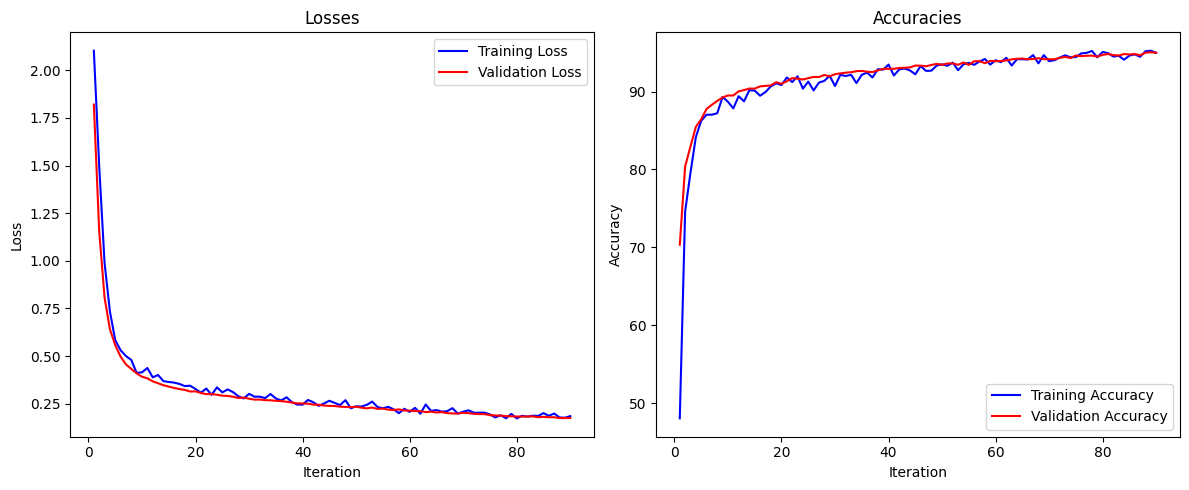

Accuracy: 95 %


In [ ]:
input_size = 784
num_classes = 10
lr = 2e-3
num_epochs = 5

# Instantiate 1-Layer Model
net = Net(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# Train Model
train_losses, train_accuracies, valid_losses, valid_accuracies = train(net, loss_function, optimizer, train_loader, test_loader, 64, num_epochs, device)

# Plot Learning Curves
plot_learning_curve(train_losses, train_accuracies, valid_losses, valid_accuracies)

# Evaluate on Test Set
test_accuracy(model=net, test_loader=test_loader, input_size=input_size, device=device)

In [ ]:
# YOUR CODE HERE (NET2)
class Net2(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net2,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=3, stride=1)
        # ((N - 2P) / S  ) + 1
        self.fc1 = nn.Linear(20 * 26 * 26, num_classes)
        self.relu = nn.ReLU()

    def forward(self,x):
        out = self.conv1(x)
        out = self.relu(out)
        out = out.view(-1, 20 * 26 * 26)
        out = self.fc1(out)
        return out

Epoch [1/5], Step [100/1875], Train Loss: 1.1556, Train Accuracy: 65.8125, Valid Loss: 0.4708, Valid Accuracy: 87.3900, Time: 1.76s
Epoch [1/5], Step [200/1875], Train Loss: 0.4329, Train Accuracy: 87.5938, Valid Loss: 0.3802, Valid Accuracy: 88.6300, Time: 3.52s
Epoch [1/5], Step [300/1875], Train Loss: 0.3830, Train Accuracy: 89.2812, Valid Loss: 0.3415, Valid Accuracy: 89.9100, Time: 5.28s
Epoch [1/5], Step [400/1875], Train Loss: 0.3508, Train Accuracy: 89.4062, Valid Loss: 0.3311, Valid Accuracy: 90.2400, Time: 7.00s
Epoch [1/5], Step [500/1875], Train Loss: 0.3508, Train Accuracy: 90.2812, Valid Loss: 0.3112, Valid Accuracy: 90.9900, Time: 9.47s
Epoch [1/5], Step [600/1875], Train Loss: 0.3677, Train Accuracy: 88.8125, Valid Loss: 0.3228, Valid Accuracy: 90.9800, Time: 11.24s
Epoch [1/5], Step [700/1875], Train Loss: 0.3267, Train Accuracy: 90.8750, Valid Loss: 0.3035, Valid Accuracy: 91.3700, Time: 13.04s
Epoch [1/5], Step [800/1875], Train Loss: 0.3233, Train Accuracy: 90.1562,

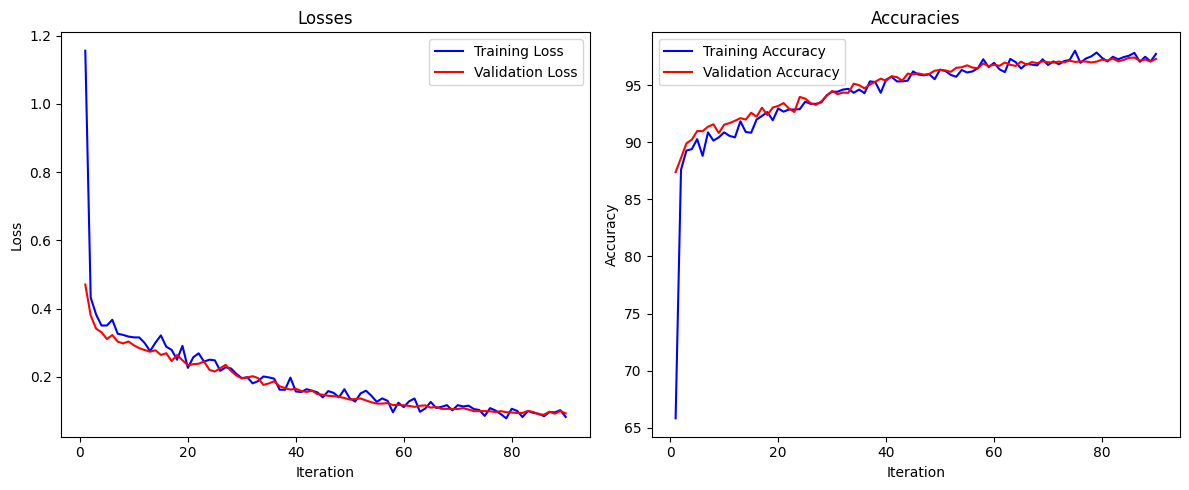

Accuracy: 97 %


In [ ]:
input_size = 784
num_classes = 10
lr = 2e-3
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# Train Model
train_losses, train_accuracies, valid_losses, valid_accuracies = train(net, loss_function, optimizer, train_loader, test_loader, 64, num_epochs, device)

# Plot Learning Curves
plot_learning_curve(train_losses, train_accuracies, valid_losses, valid_accuracies)

# Evaluate on Test Set
test_accuracy(model=net, test_loader=test_loader, input_size=input_size, device=device)

#### 5-Layer CNN
Similar to the 2-Layer model, make a new class ```Net5```

* ***Layer 1 (Input)***: Convolutional, input channel = 1, output channel = 32, kernel size = 5, stride = 1, padding = 2.
* ***Layer 2 (Hidden 1)***: Pooling, kernel size = 2, stride = 2.
* ***Layer 3 (Hidden 2)***: Convolutional, input channel = < you find out> , output channel = 64, kernel size = 5, stride = 1 padding = 2.
* ***Layer 4 (Hidden 3)***: Fully connected, input channel = < you find out>, output channel = 1024.
* ***Layer 5 (Output)***: Fully connected, input channel = < you find out>, < you find out >

In [ ]:
# YOUR CODE HERE (NET5)

# ...

# Define 5-Layer Network
class Net5(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(28 * 28 * 1, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        # print(x.shape)
        out = self.conv1(x)
        out = self.relu(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.relu(out)
#         out = self.pool2(out)
        out = x.view(-1, 28 * 28 * 1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# ...

Epoch [1/5], Step [100/1875], Train Loss: 2.0426, Train Accuracy: 48.8750, Valid Loss: 1.7019, Valid Accuracy: 73.5200, Time: 1.91s
Epoch [1/5], Step [200/1875], Train Loss: 1.3852, Train Accuracy: 76.7188, Valid Loss: 1.0449, Valid Accuracy: 81.9900, Time: 4.51s
Epoch [1/5], Step [300/1875], Train Loss: 0.9027, Train Accuracy: 82.1250, Valid Loss: 0.7332, Valid Accuracy: 85.4400, Time: 6.41s
Epoch [1/5], Step [400/1875], Train Loss: 0.6792, Train Accuracy: 84.5625, Valid Loss: 0.6010, Valid Accuracy: 85.3200, Time: 8.29s
Epoch [1/5], Step [500/1875], Train Loss: 0.6022, Train Accuracy: 84.8125, Valid Loss: 0.5213, Valid Accuracy: 87.4300, Time: 10.14s
Epoch [1/5], Step [600/1875], Train Loss: 0.5058, Train Accuracy: 86.9375, Valid Loss: 0.4741, Valid Accuracy: 87.9800, Time: 11.97s
Epoch [1/5], Step [700/1875], Train Loss: 0.4769, Train Accuracy: 88.0625, Valid Loss: 0.4430, Valid Accuracy: 88.2100, Time: 13.83s
Epoch [1/5], Step [800/1875], Train Loss: 0.4609, Train Accuracy: 87.6875

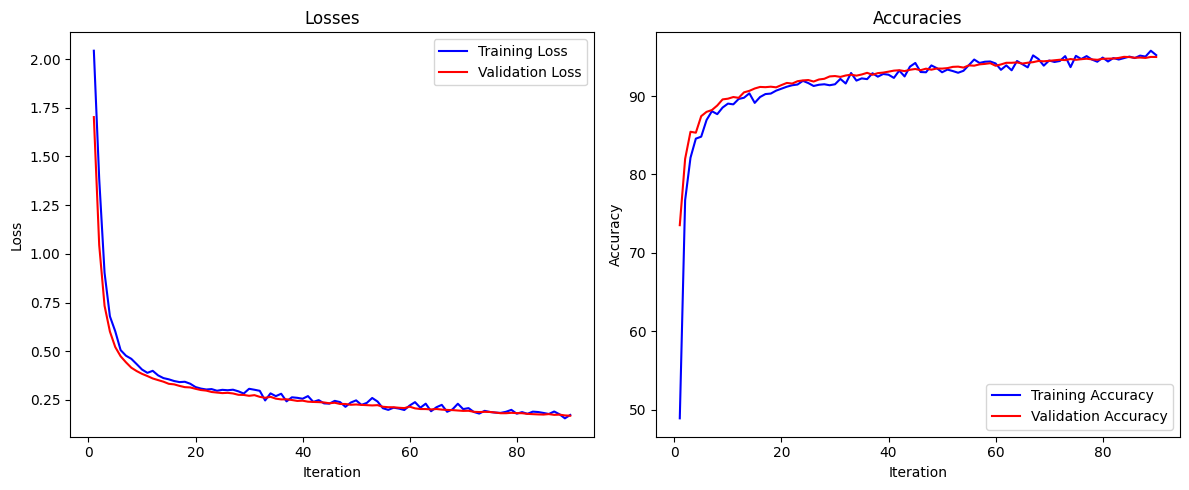

Accuracy: 95 %


In [ ]:
input_size = 784
num_classes = 10
lr = 2e-3
num_epochs = 5

# Instantiate 1-Layer Model
net = Net5(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# Train Model
train_losses, train_accuracies, valid_losses, valid_accuracies = train(net, loss_function, optimizer, train_loader, test_loader, 64, num_epochs, device)

# Plot Learning Curves
plot_learning_curve(train_losses, train_accuracies, valid_losses, valid_accuracies)

# Evaluate on Test Set
test_accuracy(model=net, test_loader=test_loader, input_size=input_size, device=device)

#### FCN

Here we will define a Fully Connected Network `FCN` (Not a CNN).

- **Layer 1 (Input):** Size = < you find out >
- **Layer 2 (Hidden 1):** 256 neurons
- **Layer 3 (Hidden 2):** 256 neurons
- **Layer 4 (Output):** Size = < you find out >

In [ ]:
# YOUR CODE HERE (FCN)

# ...

# Define FCN
class FCN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.hidden1 = nn.Linear(256, 256)
        self.hidden2 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = x.view(-1, 28 * 28 * 1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.hidden1(out)
        out = self.relu(out)
        out = self.hidden2(out)
        out = self.relu(out)
        # out = x.view(-1, 28 * 28 * 1)
        # out = self.fc1(out)
        # out = self.relu(out)
        out = self.fc2(out)
        return out

# ...

Epoch [1/5], Step [100/1875], Train Loss: 2.2969, Train Accuracy: 12.6250, Valid Loss: 2.2895, Valid Accuracy: 13.0200, Time: 1.82s
Epoch [1/5], Step [200/1875], Train Loss: 2.2807, Train Accuracy: 17.7812, Valid Loss: 2.2680, Valid Accuracy: 20.7200, Time: 3.61s
Epoch [1/5], Step [300/1875], Train Loss: 2.2529, Train Accuracy: 32.7500, Valid Loss: 2.2232, Valid Accuracy: 48.6800, Time: 6.10s
Epoch [1/5], Step [400/1875], Train Loss: 2.1751, Train Accuracy: 50.4375, Valid Loss: 2.0917, Valid Accuracy: 54.1400, Time: 7.91s
Epoch [1/5], Step [500/1875], Train Loss: 1.9201, Train Accuracy: 52.7188, Valid Loss: 1.6920, Valid Accuracy: 53.9000, Time: 9.74s
Epoch [1/5], Step [600/1875], Train Loss: 1.4245, Train Accuracy: 61.3750, Valid Loss: 1.1322, Valid Accuracy: 71.4900, Time: 11.55s
Epoch [1/5], Step [700/1875], Train Loss: 0.9687, Train Accuracy: 72.8125, Valid Loss: 0.8251, Valid Accuracy: 74.3400, Time: 13.45s
Epoch [1/5], Step [800/1875], Train Loss: 0.7644, Train Accuracy: 76.5625,

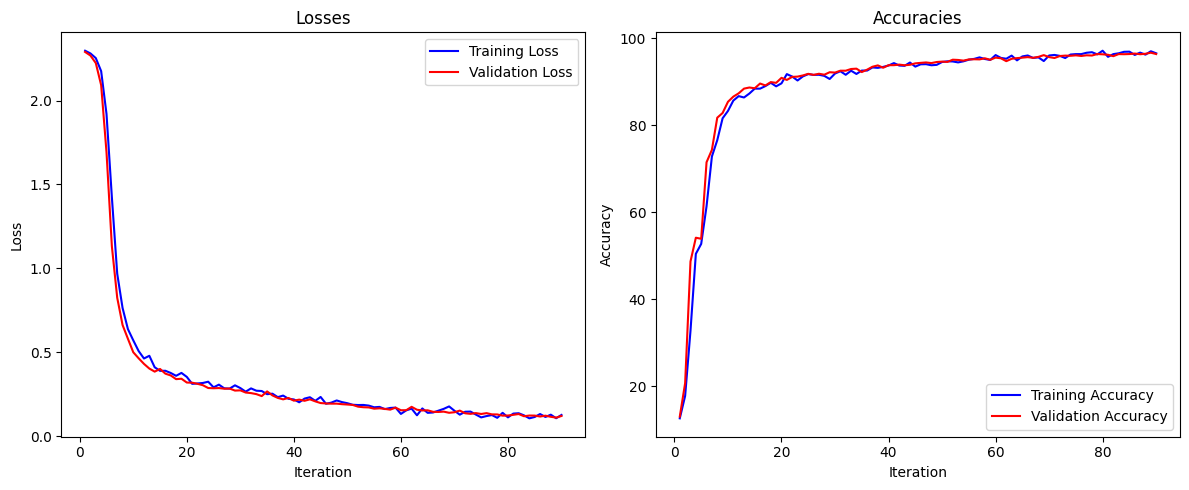

Accuracy: 96 %


In [ ]:
input_size = 784
num_classes = 10
lr = 2e-3
num_epochs = 5

# Instantiate 1-Layer Model
net = FCN(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# Train Model
train_losses, train_accuracies, valid_losses, valid_accuracies = train(net, loss_function, optimizer, train_loader, test_loader, 64, num_epochs, device)

# Plot Learning Curves
plot_learning_curve(train_losses, train_accuracies, valid_losses, valid_accuracies)

# Evaluate on Test Set
test_accuracy(model=net, test_loader=test_loader, input_size=input_size, device=device)

Q 5.7.1) Net is the best model we use since the rest of the model are overfitting despite the models having higher testing accuracies than Net.

Q 5.7.2) The Net model converges to a minimum faster compared to the other models because the Net model is a simpler neural network with fewer parameters, and it has a lower capacity. If we tune the hyperparameters, we can imrpove our model. To improve our model, we can try increasing the learning rate, decreasing our batch size and adding some regularization techniques.

Q 5.7.3) The pooling layer helps in enhancing the efficiency, robustness, and generalization of CNNs. This is done by reducing spatial dimensions, preserving important features, and mitigating overfitting.

Q 5.7.4) Yes, it is possible for a model to have a smaller final loss while having worse test accuracy. The final loss value shows how well the model fits the training data, whereas test accuracy measures how well the model generalizes the test data. This occurs due to overfitting and data mismatch.

Q 5.7.5) CNN models are made for tasks that involve grid-like data, such as images and videos, particularly in computer vision, where they excel at detecting spatial hierarchies and local patterns. FCNs, are more general-purpose and can be applied to a wide range of tasks and data types such as tabular data, natural language processing, and structured data.



---



---



### 5.8) Batch Normalization

Choose the model that performs the best (`Net`, `Net2`, `Net5`, `FCN`). Add batch normalization layers where you see fit. Repeat and train and plot learning curves.

#### **Q 5.8) Explain the purpose of the batch normalization layers,and how they affect training.**



In [ ]:
# YOUR CODE HERE
class NetWithBatchNorm(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NetWithBatchNorm, self).__init__()
        self.fc1 = nn.Linear(input_size, 500)
        self.bn1 = nn.BatchNorm1d(500)  # Add batch normalization after the first fully connected layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(500, num_classes)

    def forward(self, x):
        x = x.view(-1, input_size)
        out = self.fc1(x)
        out = self.bn1(out)  # Apply batch normalization
        out = self.relu(out)
        out = self.fc2(out)
        return out

Epoch [1/5], Step [100/1875], Train Loss: 0.9439, Train Accuracy: 73.5625, Valid Loss: 0.4527, Valid Accuracy: 88.4300, Time: 1.76s
Epoch [1/5], Step [200/1875], Train Loss: 0.3857, Train Accuracy: 88.7812, Valid Loss: 0.3226, Valid Accuracy: 90.3300, Time: 3.52s
Epoch [1/5], Step [300/1875], Train Loss: 0.3346, Train Accuracy: 90.1875, Valid Loss: 0.2955, Valid Accuracy: 91.3700, Time: 5.27s
Epoch [1/5], Step [400/1875], Train Loss: 0.2921, Train Accuracy: 91.6875, Valid Loss: 0.2778, Valid Accuracy: 91.5300, Time: 7.08s
Epoch [1/5], Step [500/1875], Train Loss: 0.2820, Train Accuracy: 91.7500, Valid Loss: 0.2425, Valid Accuracy: 93.0300, Time: 9.35s
Epoch [1/5], Step [600/1875], Train Loss: 0.2523, Train Accuracy: 92.5938, Valid Loss: 0.2278, Valid Accuracy: 93.6600, Time: 11.03s
Epoch [1/5], Step [700/1875], Train Loss: 0.2276, Train Accuracy: 93.2188, Valid Loss: 0.2079, Valid Accuracy: 93.8800, Time: 12.78s
Epoch [1/5], Step [800/1875], Train Loss: 0.2209, Train Accuracy: 93.2812,

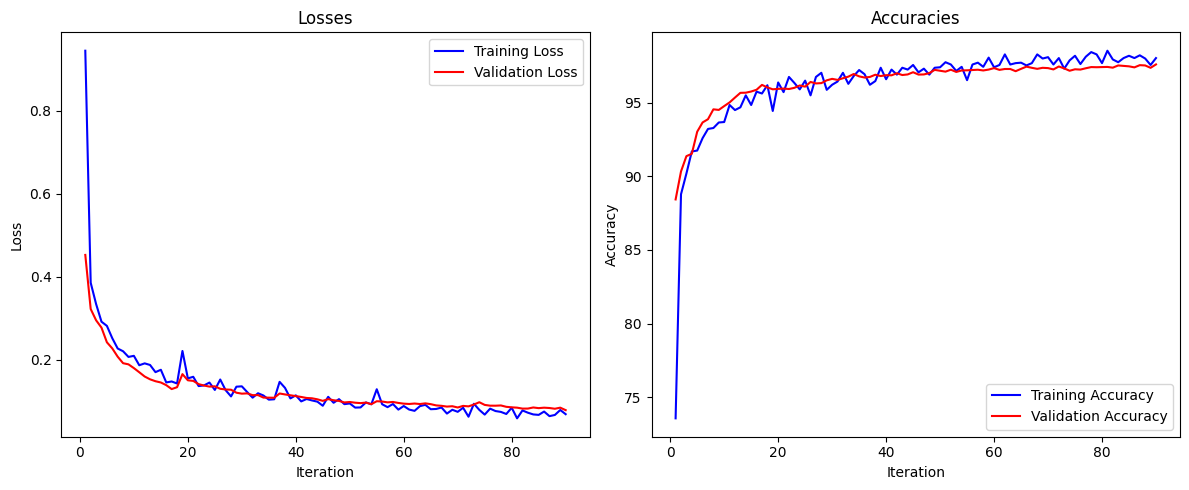

Accuracy: 97 %


In [ ]:
input_size = 784
num_classes = 10
lr = 2e-3
num_epochs = 5

# Instantiate 1-Layer Model
net = NetWithBatchNorm(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# Train Model
train_losses, train_accuracies, valid_losses, valid_accuracies = train(net, loss_function, optimizer, train_loader, test_loader, 64, num_epochs, device)

# Plot Learning Curves
plot_learning_curve(train_losses, train_accuracies, valid_losses, valid_accuracies)

# Evaluate on Test Set
test_accuracy(model=net, test_loader=test_loader, input_size=input_size, device=device)

Batch normalization layers are used to improve the training of neural networks. In the code, the batch normalization layer normalizes the activations from fc1 before passing them to the ReLU activation function.
From the learning curve with and without the batch normalization layer, we can see that the convergence speed, and final model performance has improved. In general, we can see that models with batch normalization layers tend to train faster and achieve better generalization, which means they perform well on the test data.

---